In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime

# Set plot style
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Define wavelength-specific MAC values
MAC_VALUES = {
    'UV': 18.47,    # 370/375 nm
    'Blue': 14.54,  # 470 nm
    'Green': 13.14, # 520/528 nm
    'Red': 11.58,   # 625/660 nm
    'IR': 7.77      # 880 nm
}

# Define wavelengths for all aethalometer channels
WAVELENGTHS = {
    'UV': 375,
    'Blue': 470,
    'Green': 528,
    'Red': 625,
    'IR': 880
}

def load_and_process_data(filepath):
    """
    Load and process aethalometer data, focusing only on BCc values
    """
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Convert to datetime and set timezone
    df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], utc=True)
    df['Time (Local)'] = df['Time (UTC)'].dt.tz_convert('Africa/Addis_Ababa')
    df.set_index('Time (Local)', inplace=True)
    
    # Define BCc columns to look for (only BCc, not BC1 or BC2)
    bcc_columns = [
        'UV BCc',
        'Blue BCc',
        'Green BCc',
        'Red BCc',
        'IR BCc'
    ]
    
    # Convert from ng/m³ to µg/m³ for all BCc columns
    for col in bcc_columns:
        if col in df.columns:
            df[col] = df[col] / 1000
        else:
            print(f"Warning: Column {col} not found - skipping")
    
    # Add time-based columns
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    df['Year'] = df.index.year
    df['DayOfWeek'] = df.index.dayofweek
    
    # Map Ethiopian seasons
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6-9
            return 'Kiremt Rainy Season'
    
    df['Season'] = df['Month'].apply(map_ethiopian_seasons)
    
    # Handle outliers and negative values for BCc columns
    for col in bcc_columns:
        if col in df.columns:
            # Remove negative values
            df.loc[df[col] < 0, col] = np.nan
            
            # Remove extreme outliers (3 std dev)
            mean = df[col].mean()
            std = df[col].std()
            upper_limit = mean + 3*std
            df.loc[df[col] > upper_limit, col] = np.nan
    
    print(f"Loaded data with {len(df)} rows")
    return df

def calculate_babs_from_bc(df):
    """
    Calculate absorption coefficients (babs) directly from BCc values
    using the MAC values.
    """
    # Create a copy to avoid modifying the original
    df_with_babs = df.copy()
    
    # Process each wavelength for BCc only
    for wavelength, wavelength_nm in WAVELENGTHS.items():
        bc_col = f"{wavelength} BCc"
        
        if bc_col in df.columns:
            # Calculate babs using the MAC value for this wavelength
            babs_col = f"babs_{wavelength}"
            df_with_babs[babs_col] = df[bc_col] * MAC_VALUES[wavelength]
            
            # Apply basic quality control to babs values
            # Remove non-positive values (can't take log of these)
            df_with_babs[babs_col] = df_with_babs[babs_col].mask(df_with_babs[babs_col] <= 0)
            
            print(f"Created {babs_col} from {bc_col} using MAC={MAC_VALUES[wavelength]}")
    
    return df_with_babs

def calculate_aae_pairwise_corrected(df, short_wave, long_wave):
    """
    Calculate AAE correctly using a pair of wavelengths
    Always use short wavelength to long wavelength order
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with babs values
    short_wave : str
        Shorter wavelength name (e.g., 'UV', 'Blue')
    long_wave : str
        Longer wavelength name (e.g., 'Red', 'IR')
    
    Returns:
    --------
    Series
        AAE values
    """
    # Get babs column names
    babs_short = f"babs_{short_wave}"
    babs_long = f"babs_{long_wave}"
    
    # Check if columns exist
    if babs_short not in df.columns or babs_long not in df.columns:
        print(f"Columns {babs_short} and/or {babs_long} not found")
        return None
    
    # Get wavelength values
    lambda_short = WAVELENGTHS[short_wave]
    lambda_long = WAVELENGTHS[long_wave]
    
    # Make sure wavelengths are in the right order
    if lambda_short >= lambda_long:
        print(f"Error: {short_wave} (λ={lambda_short}) should be shorter than {long_wave} (λ={lambda_long})")
        return None
    
    # Create mask for valid data (both babs values are positive)
    valid_mask = (df[babs_short] > 0) & (df[babs_long] > 0) & (~df[babs_short].isna()) & (~df[babs_long].isna())
    
    # Calculate AAE
    # AAE = -log(babs_long/babs_short) / log(lambda_long/lambda_short)
    log_babs_ratio = np.log(df.loc[valid_mask, babs_long] / df.loc[valid_mask, babs_short])
    log_wavelength_ratio = np.log(lambda_long / lambda_short)
    
    # AAE is negative of the slope
    aae = -log_babs_ratio / log_wavelength_ratio
    
    # Create a Series with the same index as df
    result = pd.Series(index=df.index, dtype=float)
    result.loc[valid_mask] = aae
    
    # Name the series
    result.name = f'AAE_{short_wave}_{long_wave}'
    
    # Print stats about the calculated AAE
    print(f"\nCalculated {result.name}:")
    print(f"Valid values: {len(aae)} out of {len(df)} rows")
    print(f"Mean AAE: {aae.mean():.3f}")
    print(f"Median AAE: {aae.median():.3f}")
    print(f"Standard deviation: {aae.std():.3f}")
    
    return result

def calculate_full_spectrum_aae(df):
    """
    Calculate AAE using linear regression across all wavelengths
    """
    # Get all babs columns
    babs_columns = [f"babs_{wave}" for wave in WAVELENGTHS.keys()]
    available_babs_columns = [col for col in babs_columns if col in df.columns]
    
    if len(available_babs_columns) < 3:
        print(f"Not enough babs columns for full spectrum calculation (found {len(available_babs_columns)})")
        return None
    
    # Get corresponding wavelengths
    available_wavelengths = []
    for col in available_babs_columns:
        # Extract wave name from column
        wave = col.split('_')[1]
        available_wavelengths.append(WAVELENGTHS[wave])
    
    # Convert to numpy arrays
    wavelength_values = np.array(available_wavelengths)
    log_wavelengths = np.log(wavelength_values)
    
    # Initialize AAE series
    aae = pd.Series(index=df.index, dtype=float)
    valid_count = 0
    
    # For each timestamp, calculate AAE using linear regression
    for idx in df.index:
        # Get babs values for this timestamp
        babs_values = []
        valid = True
        
        for col in available_babs_columns:
            if df.loc[idx, col] > 0 and not np.isnan(df.loc[idx, col]):
                babs_values.append(df.loc[idx, col])
            else:
                valid = False
                break
        
        if valid and len(babs_values) == len(available_wavelengths):
            # Take log of babs values
            log_babs = np.log(babs_values)
            
            try:
                # Calculate linear regression
                slope, _, r_value, _, _ = stats.linregress(log_wavelengths, log_babs)
                aae.loc[idx] = -slope  # AAE is negative of slope
                valid_count += 1
            except:
                # Skip if regression fails
                pass
    
    if valid_count > 0:
        print(f"\nCalculated AAE_full_spectrum:")
        print(f"Valid values: {valid_count} out of {len(df)} rows")
        
        # Calculate statistics
        valid_aae = aae.dropna()
        print(f"Mean AAE: {valid_aae.mean():.3f}")
        print(f"Median AAE: {valid_aae.median():.3f}")
        print(f"Standard deviation: {valid_aae.std():.3f}")
    else:
        print("No valid AAE values could be calculated")
    
    aae.name = 'AAE_full_spectrum'
    return aae

def filter_aae_values(aae_series, min_val=0, max_val=3):
    """
    Filter AAE values to be within a reasonable range
    """
    return aae_series.mask((aae_series < min_val) | (aae_series > max_val))

def create_aae_plots_for_large_dataset(df, aae_results, output_dir=None):
    """
    Create plots of AAE distribution and time series
    Modified to handle very large datasets
    """
    # Get AAE columns
    aae_columns = list(aae_results.columns)
    
    if not aae_columns:
        print("No AAE columns to plot")
        return
    
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Configure matplotlib for large datasets
    plt.rcParams['agg.path.chunksize'] = 10000  # Increase chunk size
    plt.rcParams['path.simplify'] = True
    plt.rcParams['path.simplify_threshold'] = 0.5  # Increase from default ~0.1
    
    # 1. Distribution of all AAE values (this should work fine)
    plt.figure(figsize=(14, 8))
    
    for col in aae_columns:
        # Filter values to reasonable range
        valid_values = aae_results[col].mask((aae_results[col] < 0) | (aae_results[col] > 3))
        
        # Plot distribution - histograms should work fine with large datasets
        sns.histplot(valid_values.dropna(), label=col, kde=True, alpha=0.5)
    
    # Add reference lines
    plt.axvline(x=1.0, color='k', linestyle='--', label='BC Reference (AAE=1)')
    plt.axvline(x=0.9, color='g', linestyle=':', label='FF Threshold')
    plt.axvline(x=1.5, color='r', linestyle=':', label='BB Threshold')
    
    plt.title('AAE Distribution')
    plt.xlabel('AAE Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 3)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'aae_distribution.png'), dpi=300)
    
    plt.close()  # Close to free memory
    
    # 2. Time series plot with downsampling
    for col in aae_columns[:3]:  # Process one column at a time to reduce memory usage
        plt.figure(figsize=(14, 8))
        
        # Filter values to reasonable range
        valid_values = aae_results[col].mask((aae_results[col] < 0) | (aae_results[col] > 3))
        
        # Downsample data - resample to daily average for time series to reduce points
        daily_values = valid_values.resample('D').mean()
        
        # Plot time series with the downsampled data
        plt.plot(daily_values.index, daily_values, label=f"{col} (Daily Avg)", alpha=0.7)
        
        # Add reference lines
        plt.axhline(y=1.0, color='k', linestyle='--', label='BC Reference (AAE=1)')
        plt.axhline(y=0.9, color='g', linestyle=':', label='FF Threshold')
        plt.axhline(y=1.5, color='r', linestyle=':', label='BB Threshold')
        
        plt.title(f'AAE Time Series - {col}')
        plt.xlabel('Time')
        plt.ylabel('AAE Value')
        plt.ylim(0, 3)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, f'aae_time_series_{col}.png'), dpi=300)
        
        plt.close()  # Close to free memory
    
    # 3. Seasonal distribution of AAE
    if 'Season' in df.columns:
        # Create one plot per AAE calculation method
        for i, col in enumerate(aae_columns[:3]):  # Limit to 3 columns
            plt.figure(figsize=(10, 6))
            
            # Filter values to reasonable range
            valid_values = aae_results[col].mask((aae_results[col] < 0) | (aae_results[col] > 3))
            
            # Create a temporary df for plotting - use a random sample to reduce size
            if len(valid_values) > 100000:
                # Get a random sample of 100,000 points
                random_indices = np.random.choice(valid_values.index, size=100000, replace=False)
                temp_df = pd.DataFrame({
                    'AAE': valid_values.loc[random_indices],
                    'Season': df.loc[random_indices, 'Season']
                })
            else:
                temp_df = pd.DataFrame({
                    'AAE': valid_values,
                    'Season': df['Season']
                })
            
            # Drop NaN values
            temp_df = temp_df.dropna()
            
            # Define season order
            season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
            
            # Create box plot
            sns.boxplot(data=temp_df, x='Season', y='AAE', order=season_order)
            
            # Add reference lines
            plt.axhline(y=1.0, color='k', linestyle='--', label='BC Reference (AAE=1)')
            plt.axhline(y=0.9, color='g', linestyle=':', label='FF Threshold')
            plt.axhline(y=1.5, color='r', linestyle=':', label='BB Threshold')
            
            plt.title(f'Seasonal AAE Distribution - {col}')
            plt.xlabel('')
            plt.ylabel('AAE Value')
            plt.ylim(0, 3)
            plt.xticks(rotation=45)
            plt.legend()
            
            if output_dir:
                plt.savefig(os.path.join(output_dir, f'aae_seasonal_{col}.png'), dpi=300)
            
            plt.close()  # Close to free memory

def calculate_source_attribution(aae_results):
    """
    Calculate source attribution percentages based on AAE thresholds
    """
    print("\nSource Attribution Based on AAE Thresholds:")
    print("-" * 60)
    
    for col in aae_results.columns:
        # Get valid AAE values
        valid_aae = filter_aae_values(aae_results[col]).dropna()
        
        if len(valid_aae) == 0:
            print(f"No valid data for {col}")
            continue
        
        # Calculate percentages
        ff_pct = (valid_aae < 0.9).mean() * 100
        mixed_pct = ((valid_aae >= 0.9) & (valid_aae <= 1.5)).mean() * 100
        bb_pct = (valid_aae > 1.5).mean() * 100
        
        # Print results
        print(f"\n{col}:")
        print(f"Mean AAE: {valid_aae.mean():.2f}")
        print(f"Median AAE: {valid_aae.median():.2f}")
        print(f"Fossil Fuel (AAE < 0.9): {ff_pct:.1f}%")
        print(f"Mixed (0.9 ≤ AAE ≤ 1.5): {mixed_pct:.1f}%")
        print(f"Biomass Burning (AAE > 1.5): {bb_pct:.1f}%")
    
    print("-" * 60)

def analyze_seasonal_source_attribution(df, aae_results):
    """
    Analyze seasonal patterns in source attribution
    """
    # Define season order
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    print("\nSeasonal Source Attribution:")
    print("-" * 60)
    
    for col in aae_results.columns:
        print(f"\n{col}:")
        
        # Get valid AAE values
        valid_aae = filter_aae_values(aae_results[col])
        
        # Create a temporary DataFrame with season info
        temp_df = pd.DataFrame({
            'AAE': valid_aae,
            'Season': df['Season']
        }).dropna()
        
        # Calculate seasonal statistics
        for season in season_order:
            season_aae = temp_df[temp_df['Season'] == season]['AAE']
            
            if len(season_aae) == 0:
                print(f"  {season}: No valid data")
                continue
            
            # Calculate percentages
            ff_pct = (season_aae < 0.9).mean() * 100
            mixed_pct = ((season_aae >= 0.9) & (season_aae <= 1.5)).mean() * 100
            bb_pct = (season_aae > 1.5).mean() * 100
            
            print(f"  {season}:")
            print(f"    Mean AAE: {season_aae.mean():.2f}")
            print(f"    Fossil Fuel: {ff_pct:.1f}%")
            print(f"    Mixed: {mixed_pct:.1f}%")
            print(f"    Biomass Burning: {bb_pct:.1f}%")
    
    print("-" * 60)

def main():
    """
    Main function to run AAE analysis using only BCc values
    """
    # Set output directory
    output_dir = 'output/aae_bcc_only'
    os.makedirs(output_dir, exist_ok=True)
    
    # File path to your data
    filepath = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    
    # 1. Load and process data
    print("Loading and processing data...")
    df = load_and_process_data(filepath)
    
    # 2. Calculate absorption coefficients from BCc values
    print("\nCalculating absorption coefficients...")
    df_with_babs = calculate_babs_from_bc(df)
    
    # 3. Calculate AAE using different methods
    print("\nCalculating AAE values...")
    
    # Calculate AAE for key wavelength pairs (UV-IR and Blue-IR)
    aae_uv_ir = calculate_aae_pairwise_corrected(df_with_babs, 'UV', 'IR')
    aae_blue_ir = calculate_aae_pairwise_corrected(df_with_babs, 'Blue', 'IR')
    
    # Calculate full-spectrum AAE
    aae_full = calculate_full_spectrum_aae(df_with_babs)
    
    # Combine results into a dataframe
    aae_results = pd.DataFrame()
    
    if aae_uv_ir is not None:
        aae_results[aae_uv_ir.name] = aae_uv_ir
    
    if aae_blue_ir is not None:
        aae_results[aae_blue_ir.name] = aae_blue_ir
    
    if aae_full is not None:
        aae_results[aae_full.name] = aae_full
    
    # 4. Create visualizations
    print("\nCreating plots...")
    create_aae_plots_for_large_dataset(df, aae_results, output_dir)
    
    # 5. Calculate source attribution
    calculate_source_attribution(aae_results)
    
    # 6. Analyze seasonal patterns
    analyze_seasonal_source_attribution(df, aae_results)
    
    # 7. Save results
    print("\nSaving results...")
    aae_results.to_csv(os.path.join(output_dir, 'aae_results_bcc_only.csv'))
    
    print(f"\nAnalysis complete! Results saved to {output_dir}")
    
    return {
        'df': df,
        'df_with_babs': df_with_babs,
        'aae_results': aae_results
    }

if __name__ == "__main__":
    main()

Loading and processing data...
Loaded data with 1095086 rows

Calculating absorption coefficients...
Created babs_UV from UV BCc using MAC=18.47
Created babs_Blue from Blue BCc using MAC=14.54
Created babs_Green from Green BCc using MAC=13.14
Created babs_Red from Red BCc using MAC=11.58
Created babs_IR from IR BCc using MAC=7.77

Calculating AAE values...

Calculated AAE_UV_IR:
Valid values: 1016067 out of 1095086 rows
Mean AAE: 0.982
Median AAE: 0.992
Standard deviation: 0.686

Calculated AAE_Blue_IR:
Valid values: 1029249 out of 1095086 rows
Mean AAE: 1.068
Median AAE: 1.045
Standard deviation: 0.864

Calculated AAE_full_spectrum:
Valid values: 989781 out of 1095086 rows
Mean AAE: 0.989
Median AAE: 0.990
Standard deviation: 0.609

Creating plots...

Source Attribution Based on AAE Thresholds:
------------------------------------------------------------

AAE_UV_IR:
Mean AAE: 1.03
Median AAE: 1.01
Fossil Fuel (AAE < 0.9): 37.9%
Mixed (0.9 ≤ AAE ≤ 1.5): 50.8%
Biomass Burning (AAE > 1.5


Starting AAE analysis...
Loading data from /Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv
Sample of column names: ['Serial number', 'Time (UTC)', 'Datum ID', 'Session ID', 'Data format version', 'Firmware version', 'App version', 'Timezone offset (mins)', 'Date local (yyyy/MM/dd)', 'Time local (hh:mm:ss)']
Loaded data with 1095086 rows

Calculating absorption coefficients from ATN columns...
Couldn't calculate babs directly from ATN columns, trying BC-based approach
Calculated babs_UV from UV BC1 using MAC=18.47
Calculated babs_Blue from Blue BC1 using MAC=14.54
Calculated babs_Green from Green BC1 using MAC=13.14
Calculated babs_Red from Red BC1 using MAC=11.58
Calculated babs_IR from IR BC1 using MAC=7.77

Calculating AAE using direct method (without MAC)...

Calculated AAE_UV_IR_direct:
Valid values: 1092636 out of 1095086 rows
Mean AAE: 0.6

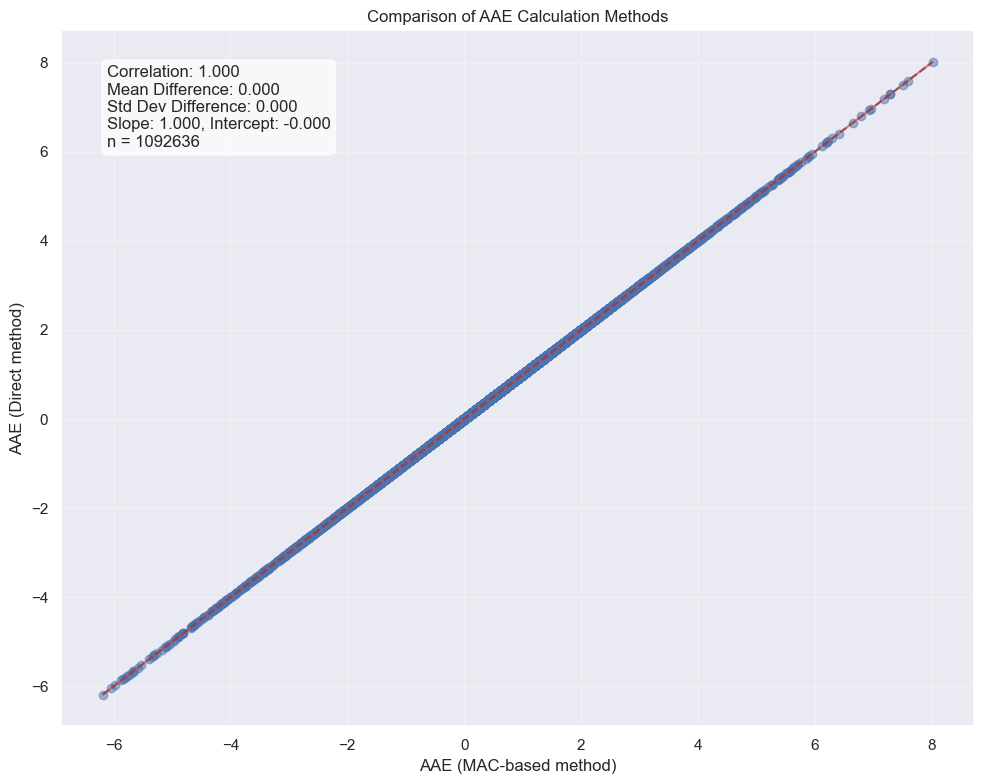

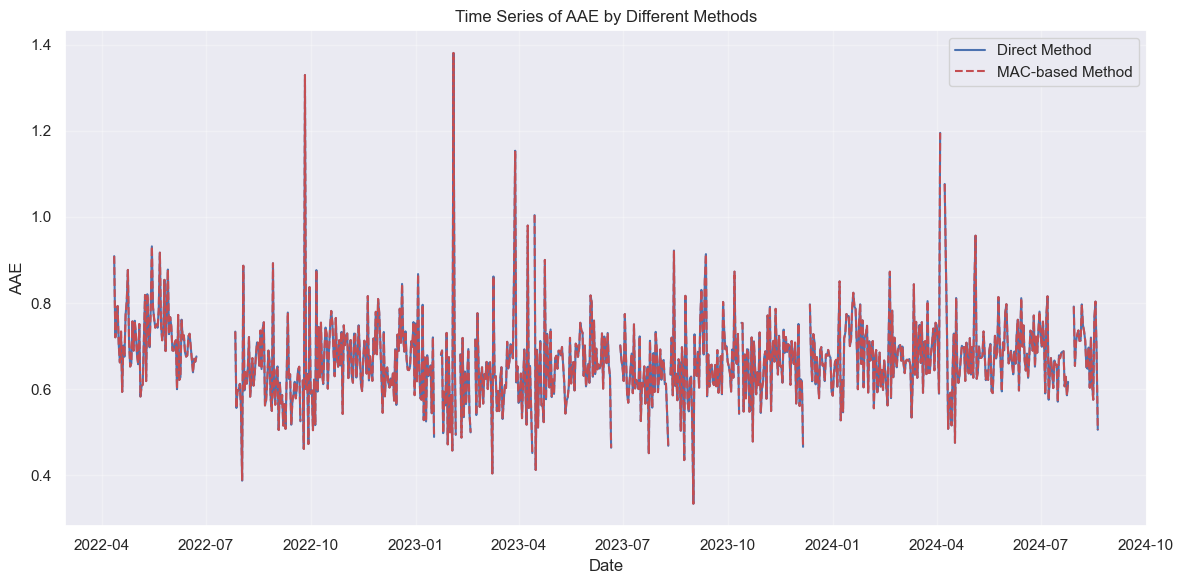

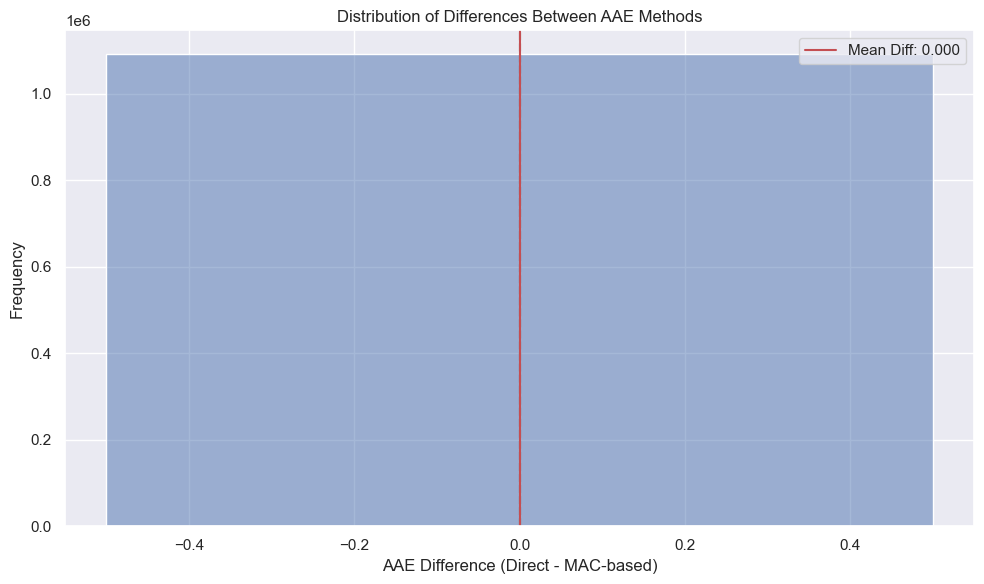

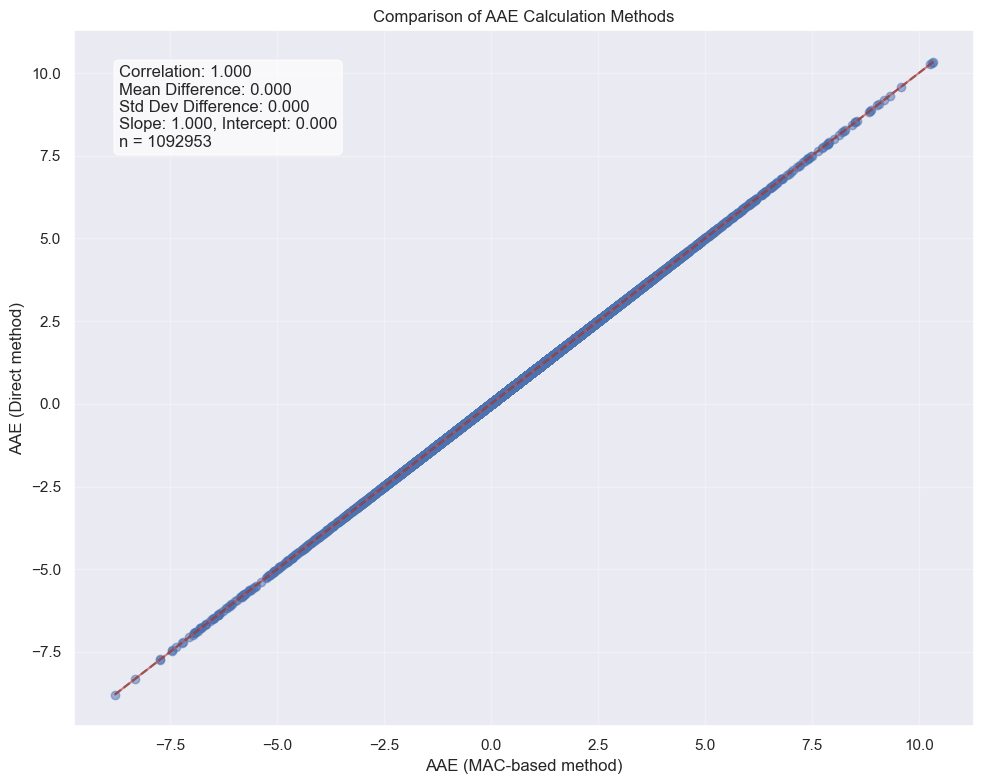

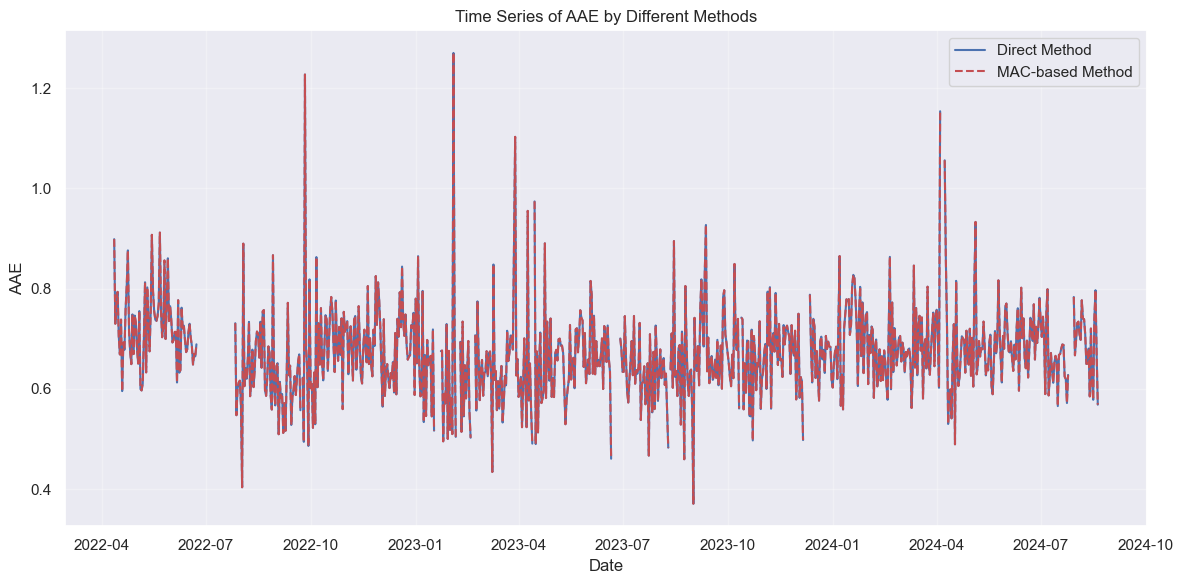

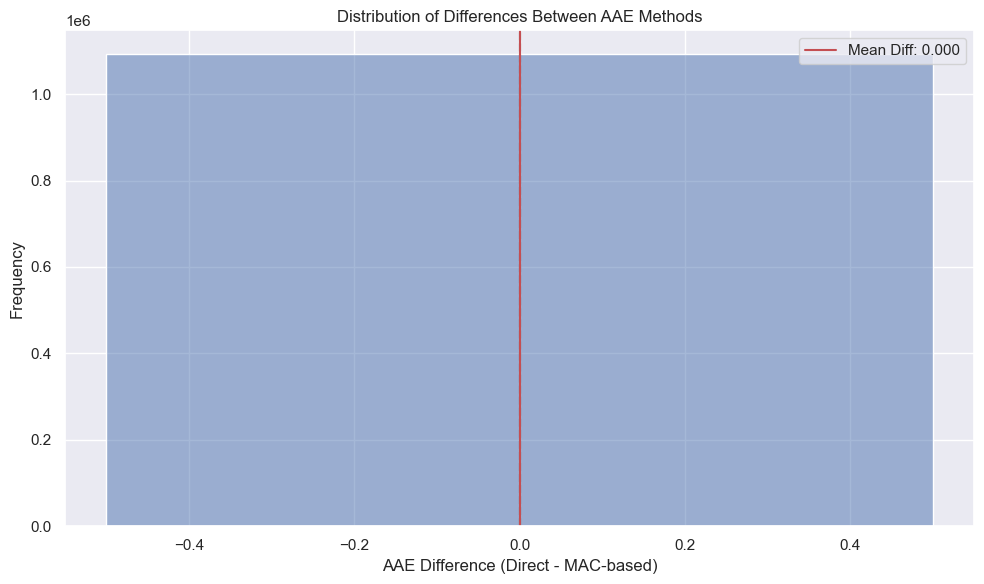

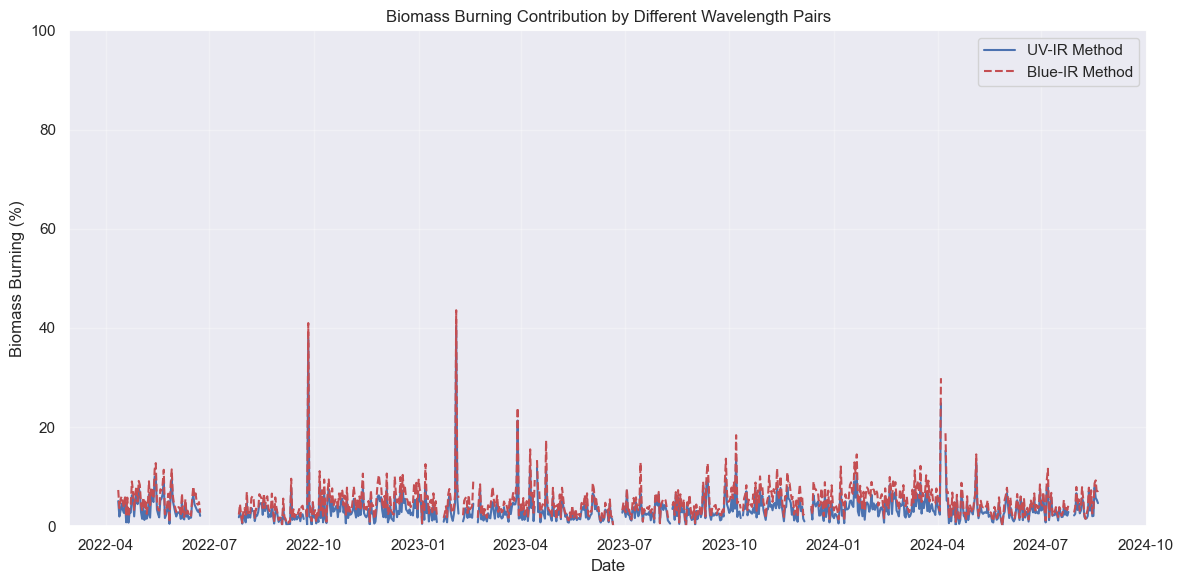

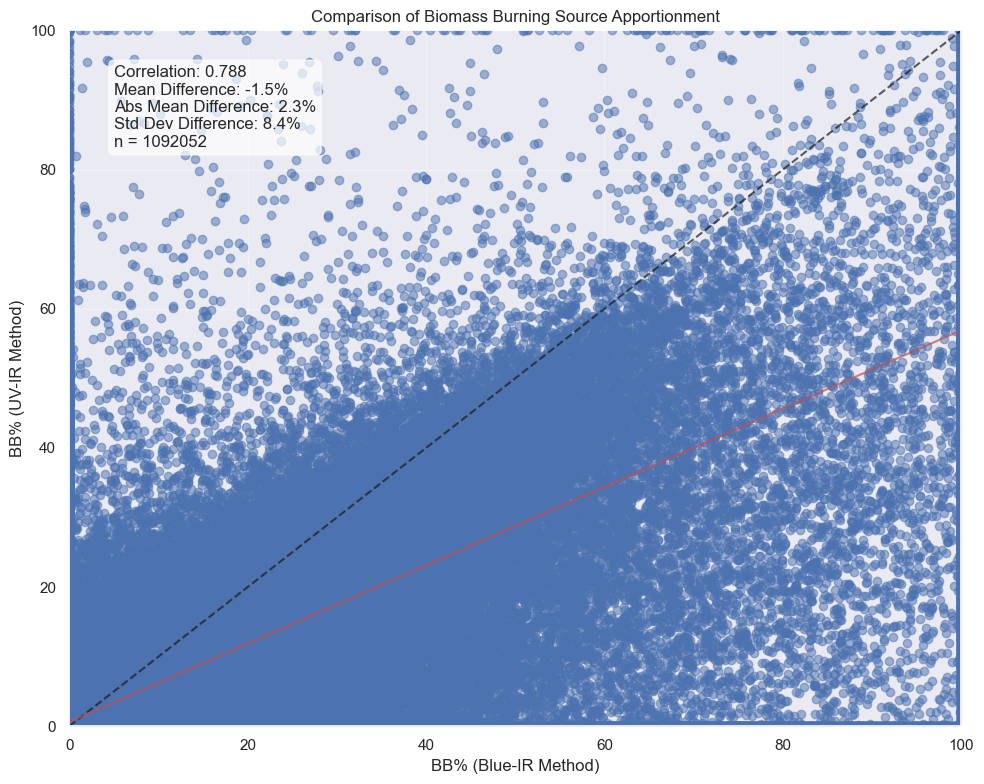

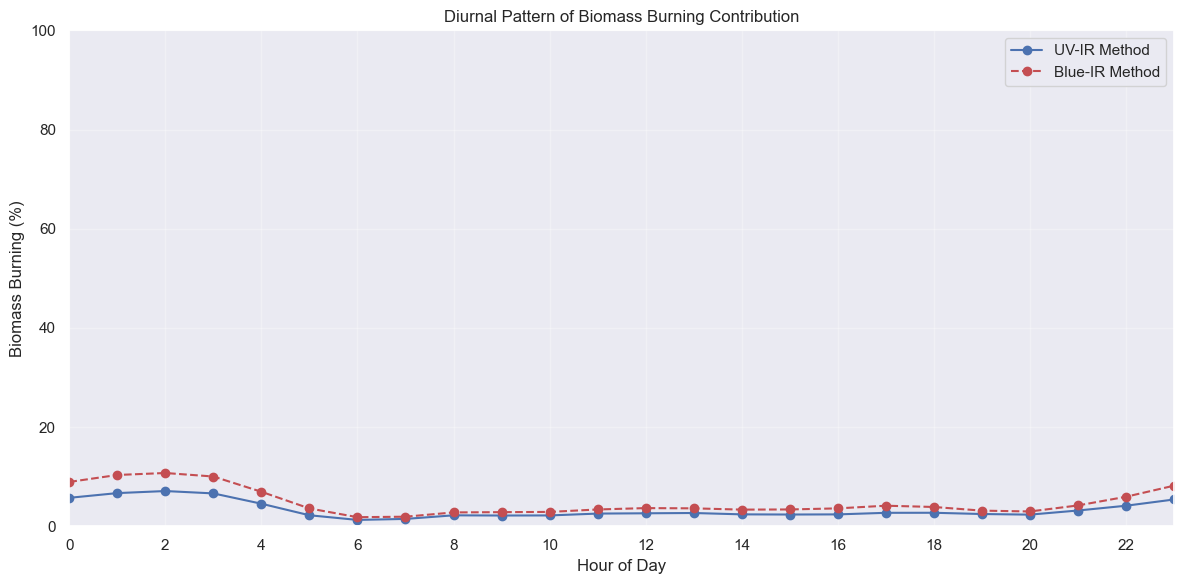

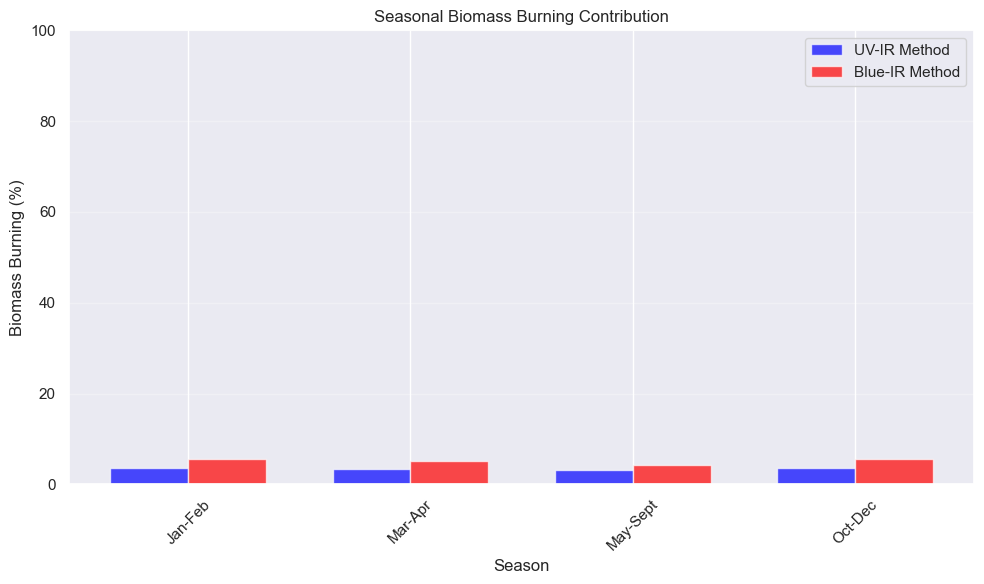

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime

# Set plot style
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Define wavelengths for all aethalometer channels
WAVELENGTHS = {
    'UV': 375,
    'Blue': 470,
    'Green': 528,
    'Red': 625,
    'IR': 880
}

# Define wavelength-specific MAC values (from Chakraborty et al. 2023)
MAC_VALUES = {
    'UV': 18.47,    # 370/375 nm
    'Blue': 14.54,  # 470 nm
    'Green': 13.14, # 520/528 nm
    'Red': 11.58,   # 625/660 nm
    'IR': 7.77      # 880 nm
}

def load_and_process_data(filepath):
    """
    Load and process aethalometer data
    """
    # Read the CSV file
    print(f"Loading data from {filepath}")
    df = pd.read_csv(filepath)
    
    # Check column presence and print a sample of column names
    print(f"Sample of column names: {list(df.columns)[:10]}")
    
    # Convert to datetime and set timezone if needed
    if 'Time (UTC)' in df.columns:
        df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], utc=True)
        # Check if 'Time (Local)' needs to be created
        if 'Time (Local)' not in df.columns:
            df['Time (Local)'] = df['Time (UTC)'].dt.tz_convert('Africa/Addis_Ababa')
        df.set_index('Time (Local)', inplace=True)
    elif 'time_utc' in df.columns:
        df['time_utc'] = pd.to_datetime(df['time_utc'], utc=True)
        # Create local time from UTC with timezone offset
        if 'timezone_offset_mins' in df.columns:
            df['Time (Local)'] = df['time_utc'] + pd.to_timedelta(df['timezone_offset_mins'], unit='m')
        else:
            df['Time (Local)'] = df['time_utc']
        df.set_index('Time (Local)', inplace=True)
    
    # Add time-based columns
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    df['Year'] = df.index.year
    df['DayOfWeek'] = df.index.dayofweek
    
    # Map Ethiopian seasons or use custom seasons from paper
    def map_paper_seasons(month):
        if month in [1, 2]:
            return 'Jan-Feb'
        elif month in [3, 4]:
            return 'Mar-Apr'
        elif month in [5, 6, 7, 8, 9]:
            return 'May-Sept'
        else:  # 10, 11, 12
            return 'Oct-Dec'
    
    df['Season'] = df['Month'].apply(map_paper_seasons)
    
    print(f"Loaded data with {len(df)} rows")
    return df

def calculate_babs_from_atn_columns(df):
    """
    Calculate absorption coefficients (babs) directly from ATN columns
    using equation: babs(λ) = (F × (1-ξ) × C × (1-k·ATN(λ)) × Δt × 100) / (A × ΔATN(λ))
    """
    df_babs = df.copy()
    processed_channels = []
    
    # Constants from the AE33 and MA300 specifications
    spot_area = 0.785  # cm²
    C = 1.39  # Multiple scattering enhancement factor (from Chakraborty paper)
    xi = 0.01  # Filter leakage factor (1%)
    
    # Wavelength mapping to lowercase for column matching
    wavelength_map = {
        'uv': 'UV',
        'blue': 'Blue',
        'green': 'Green',
        'red': 'Red',
        'ir': 'IR'
    }
    
    # Check for ATN columns
    for wave_lower, wave_upper in wavelength_map.items():
        # Check for presence of ATN columns
        atn1_col = f'{wave_lower}_atn1'
        atn2_col = f'{wave_lower}_atn2'
        
        # Check if flow columns exist
        flow1_col = 'flow1_ml_min'
        flow2_col = 'flow2_ml_min'
        flow_total_col = 'flow_total_ml_min'
        
        # If both columns exist, we can calculate babs
        if (atn1_col in df.columns and atn2_col in df.columns and 
            flow1_col in df.columns and flow2_col in df.columns):
            
            print(f"Found ATN columns for {wave_upper} channel")
            
            # Get flow rates in m³/s (convert from mL/min)
            flow1 = df[flow1_col] / (1000 * 60 * 1000)  # mL/min to m³/s
            flow2 = df[flow2_col] / (1000 * 60 * 1000)  # mL/min to m³/s
            
            # Convert spot area from cm² to m²
            spot_area_m2 = spot_area / 10000
            
            # Calculate time difference in seconds
            delta_t = df.index.to_series().diff().dt.total_seconds()
            
            # Calculate ATN changes
            atn1 = df[atn1_col]
            atn2 = df[atn2_col]
            
            delta_atn1 = atn1.diff()
            delta_atn2 = atn2.diff()
            
            # Estimate loading correction parameter k
            # Using equation from Drinovec et al. (2015)
            # (flow2/flow1) = ln(1-k*atn2) / ln(1-k*atn1)
            # To solve this, we'll use a default k value first
            k = 0.005  # Default loading correction parameter
            
            # Calculate babs for spot 1 using full equation
            # babs(λ) = (F × (1-ξ) × C × (1-k·ATN(λ)) × Δt × 100) / (A × ΔATN(λ))
            babs1 = (flow1 * (1-xi) * C * (1-k*atn1) * 100) / (spot_area_m2 * delta_atn1)
            
            # Calculate babs for spot 2
            babs2 = (flow2 * (1-xi) * C * (1-k*atn2) * 100) / (spot_area_m2 * delta_atn2)
            
            # Take the weighted average of the two spots
            # Use flow ratio as weight
            flow_total = df[flow_total_col]
            weight1 = flow1 / flow_total
            weight2 = flow2 / flow_total
            
            babs = (babs1 * weight1 + babs2 * weight2)
            
            # Clean up: Filter out invalid values and outliers
            babs = babs.mask(babs <= 0)  # Remove non-positive values
            babs = babs.mask(~np.isfinite(babs))  # Remove infinity and NaN
            
            # Remove extreme outliers (3 std dev)
            mean_babs = babs.mean()
            std_babs = babs.std()
            babs = babs.mask((babs > mean_babs + 3*std_babs) | (babs < mean_babs - 3*std_babs))
            
            # Store the result
            col_name = f'babs_{wave_upper}'
            df_babs[col_name] = babs
            processed_channels.append(wave_upper)
            
            print(f"Calculated {col_name} directly from ATN columns")
            print(f"Mean value: {babs.mean():.2f} Mm⁻¹, Valid data points: {babs.count()}")
    
    if not processed_channels:
        # Alternative method using BC and MAC values if ATN columns failed
        print("Couldn't calculate babs directly from ATN columns, trying BC-based approach")
        df_babs = calculate_babs_from_bc(df)
        processed_channels = [wave for wave in WAVELENGTHS.keys() if f'babs_{wave}' in df_babs.columns]
    
    return df_babs, processed_channels

def calculate_babs_from_bc(df):
    """
    Calculate absorption coefficients (babs) from BC values
    using MAC values (fallback method)
    """
    df_babs = df.copy()
    processed_channels = []
    
    # BC column patterns to try
    bc_patterns = [
        # Capital letter variants
        "{} BC1", "{} BC2", "{} BCc",
        # Lowercase variants
        "{}_bc1", "{}_bc2", "{}_bcc",
        # Variants with spaces
        "{} bc1", "{} bc2", "{} bcc"
    ]
    
    for wavelength, wavelength_nm in WAVELENGTHS.items():
        bc_col = None
        
        # Try to find the BC column for this wavelength
        for pattern in bc_patterns:
            col = pattern.format(wavelength)
            if col in df.columns:
                bc_col = col
                break
            
            # Also try lowercase wavelength
            col = pattern.format(wavelength.lower())
            if col in df.columns:
                bc_col = col
                break
        
        if bc_col is not None:
            # Check if we need to convert from ng/m³ to μg/m³
            if df[bc_col].mean() > 100:  # Likely in ng/m³
                df[bc_col] = df[bc_col] / 1000
                
            # Calculate babs using MAC value
            mac = MAC_VALUES[wavelength]
            df_babs[f'babs_{wavelength}'] = df[bc_col] * mac
            processed_channels.append(wavelength)
            
            print(f"Calculated babs_{wavelength} from {bc_col} using MAC={mac}")
    
    return df_babs

def calculate_aae_direct(df, short_wave, long_wave):
    """
    Calculate AAE directly using a pair of wavelengths
    """
    # Get babs column names
    babs_short = f"babs_{short_wave}"
    babs_long = f"babs_{long_wave}"
    
    # Check if columns exist
    if babs_short not in df.columns or babs_long not in df.columns:
        print(f"Columns {babs_short} and/or {babs_long} not found")
        return None
    
    # Get wavelength values
    lambda_short = WAVELENGTHS[short_wave]
    lambda_long = WAVELENGTHS[long_wave]
    
    # Make sure wavelengths are in the right order
    if lambda_short >= lambda_long:
        print(f"Error: {short_wave} (λ={lambda_short}) should be shorter than {long_wave} (λ={lambda_long})")
        return None
    
    # Create mask for valid data (both babs values are positive and not NaN)
    valid_mask = (df[babs_short] > 0) & (df[babs_long] > 0) & (~df[babs_short].isna()) & (~df[babs_long].isna())
    
    # Calculate AAE
    # AAE = -log(babs_long/babs_short) / log(lambda_long/lambda_short)
    log_babs_ratio = np.log(df.loc[valid_mask, babs_long] / df.loc[valid_mask, babs_short])
    log_wavelength_ratio = np.log(lambda_long / lambda_short)
    
    # AAE is negative of the slope
    aae = -log_babs_ratio / log_wavelength_ratio
    
    # Create a Series with the same index as df
    result = pd.Series(index=df.index, dtype=float)
    result.loc[valid_mask] = aae
    
    # Name the series
    result.name = f'AAE_{short_wave}_{long_wave}_direct'
    
    # Print stats about the calculated AAE
    print(f"\nCalculated {result.name}:")
    print(f"Valid values: {len(aae)} out of {len(df)} rows")
    print(f"Mean AAE: {aae.mean():.3f}")
    print(f"Median AAE: {aae.median():.3f}")
    print(f"Standard deviation: {aae.std():.3f}")
    
    return result

def calculate_full_spectrum_aae_direct(df):
    """
    Calculate AAE using linear regression across all wavelengths
    """
    # Get all babs columns
    babs_columns = [col for col in df.columns if col.startswith('babs_')]
    
    if len(babs_columns) < 3:
        print(f"Not enough babs columns for full spectrum calculation (found {len(babs_columns)})")
        return None
    
    # Get corresponding wavelengths
    available_wavelengths = []
    for col in babs_columns:
        # Extract wave name from column
        wave = col.split('_')[1]
        if wave in WAVELENGTHS:
            available_wavelengths.append(WAVELENGTHS[wave])
    
    # Convert to numpy arrays
    wavelength_values = np.array(available_wavelengths)
    log_wavelengths = np.log(wavelength_values)
    
    # Initialize AAE series
    aae = pd.Series(index=df.index, dtype=float)
    valid_count = 0
    
    # For each timestamp, calculate AAE using linear regression
    for idx in df.index:
        # Get babs values for this timestamp
        babs_values = []
        valid = True
        
        for col in babs_columns:
            if df.loc[idx, col] > 0 and not np.isnan(df.loc[idx, col]):
                babs_values.append(df.loc[idx, col])
            else:
                valid = False
                break
        
        if valid and len(babs_values) == len(available_wavelengths):
            # Take log of babs values
            log_babs = np.log(babs_values)
            
            try:
                # Calculate linear regression
                slope, _, r_value, _, _ = stats.linregress(log_wavelengths, log_babs)
                aae.loc[idx] = -slope  # AAE is negative of slope
                valid_count += 1
            except:
                # Skip if regression fails
                pass
    
    if valid_count > 0:
        print(f"\nCalculated AAE_full_spectrum_direct:")
        print(f"Valid values: {valid_count} out of {len(df)} rows")
        
        # Calculate statistics
        valid_aae = aae.dropna()
        print(f"Mean AAE: {valid_aae.mean():.3f}")
        print(f"Median AAE: {valid_aae.median():.3f}")
        print(f"Standard deviation: {valid_aae.std():.3f}")
    else:
        print("No valid AAE values could be calculated")
    
    aae.name = 'AAE_full_spectrum_direct'
    return aae

def calculate_aae_mac_based(df, short_wave, long_wave):
    """
    Calculate AAE using a pair of wavelengths based on BC and MAC values
    for comparison with direct method
    """
    # BC column patterns to try
    bc_patterns = [
        # Capital letter variants
        "{} BC1", "{} BC2", "{} BCc",
        # Lowercase variants
        "{}_bc1", "{}_bc2", "{}_bcc",
        # Variants with spaces
        "{} bc1", "{} bc2", "{} bcc"
    ]
    
    # Find BC columns for both wavelengths
    bc_short_col = None
    bc_long_col = None
    
    for pattern in bc_patterns:
        col = pattern.format(short_wave)
        if col in df.columns:
            bc_short_col = col
            break
        
        # Try lowercase
        col = pattern.format(short_wave.lower())
        if col in df.columns:
            bc_short_col = col
            break
    
    for pattern in bc_patterns:
        col = pattern.format(long_wave)
        if col in df.columns:
            bc_long_col = col
            break
        
        # Try lowercase
        col = pattern.format(long_wave.lower())
        if col in df.columns:
            bc_long_col = col
            break
    
    # Check if we found the columns
    if bc_short_col is None or bc_long_col is None:
        print(f"BC columns for {short_wave} and/or {long_wave} not found")
        return None
        
    # Get wavelength values
    lambda_short = WAVELENGTHS[short_wave]
    lambda_long = WAVELENGTHS[long_wave]
    
    # Get MAC values
    mac_short = MAC_VALUES[short_wave]
    mac_long = MAC_VALUES[long_wave]
    
    # Make sure wavelengths are in the right order
    if lambda_short >= lambda_long:
        print(f"Error: {short_wave} (λ={lambda_short}) should be shorter than {long_wave} (λ={lambda_long})")
        return None
    
    # Check if we need to convert from ng/m³ to μg/m³
    if df[bc_short_col].mean() > 100:  # Likely in ng/m³
        df[bc_short_col] = df[bc_short_col] / 1000
    
    if df[bc_long_col].mean() > 100:  # Likely in ng/m³
        df[bc_long_col] = df[bc_long_col] / 1000
    
    # Create mask for valid data (both BC values are positive)
    valid_mask = (df[bc_short_col] > 0) & (df[bc_long_col] > 0) & (~df[bc_short_col].isna()) & (~df[bc_long_col].isna())
    
    # Calculate babs from BC and MAC
    babs_short = df.loc[valid_mask, bc_short_col] * mac_short
    babs_long = df.loc[valid_mask, bc_long_col] * mac_long
    
    # Calculate AAE
    # AAE = -log(babs_long/babs_short) / log(lambda_long/lambda_short)
    log_babs_ratio = np.log(babs_long / babs_short)
    log_wavelength_ratio = np.log(lambda_long / lambda_short)
    
    # AAE is negative of the slope
    aae = -log_babs_ratio / log_wavelength_ratio
    
    # Create a Series with the same index as df
    result = pd.Series(index=df.index, dtype=float)
    result.loc[valid_mask] = aae
    
    # Name the series
    result.name = f'AAE_{short_wave}_{long_wave}_mac_based'
    
    # Print stats about the calculated AAE
    print(f"\nCalculated {result.name}:")
    print(f"Valid values: {len(aae)} out of {len(df)} rows")
    print(f"Mean AAE: {aae.mean():.3f}")
    print(f"Median AAE: {aae.median():.3f}")
    print(f"Standard deviation: {aae.std():.3f}")
    
    return result

def compare_aae_methods(df, direct_aae, mac_aae, output_dir=None):
    """
    Compare AAE values calculated by different methods
    """
    if direct_aae is None or mac_aae is None:
        print("Missing data for comparison - at least one AAE method failed")
        return None
    
    # Create a new DataFrame for comparison
    compare_df = pd.DataFrame({
        'AAE_direct': direct_aae,
        'AAE_mac_based': mac_aae
    })
    
    # Remove rows with NaN values
    compare_df = compare_df.dropna()
    
    if len(compare_df) == 0:
        print("No valid data for comparison after removing NaN values")
        return None
    
    # Calculate correlation
    correlation = compare_df['AAE_direct'].corr(compare_df['AAE_mac_based'])
    
    # Calculate mean difference and standard deviation
    compare_df['difference'] = compare_df['AAE_direct'] - compare_df['AAE_mac_based']
    mean_diff = compare_df['difference'].mean()
    std_diff = compare_df['difference'].std()
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(compare_df['AAE_mac_based'], compare_df['AAE_direct'], alpha=0.5)
    
    # Plot reference line (1:1)
    min_val = min(compare_df['AAE_mac_based'].min(), compare_df['AAE_direct'].min())
    max_val = max(compare_df['AAE_mac_based'].max(), compare_df['AAE_direct'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)
    
    # Add linear fit
    fit = np.polyfit(compare_df['AAE_mac_based'], compare_df['AAE_direct'], 1)
    fit_line = np.poly1d(fit)
    plt.plot(np.sort(compare_df['AAE_mac_based']), 
             fit_line(np.sort(compare_df['AAE_mac_based'])), 
             'r-', alpha=0.7)
    
    # Add statistics as text
    stats_text = (
        f"Correlation: {correlation:.3f}\n"
        f"Mean Difference: {mean_diff:.3f}\n"
        f"Std Dev Difference: {std_diff:.3f}\n"
        f"Slope: {fit[0]:.3f}, Intercept: {fit[1]:.3f}\n"
        f"n = {len(compare_df)}"
    )
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=props)
    
    plt.title('Comparison of AAE Calculation Methods')
    plt.xlabel('AAE (MAC-based method)')
    plt.ylabel('AAE (Direct method)')
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'aae_methods_comparison.png'), dpi=300)
    
    plt.tight_layout()
    
    # Create time series comparison
    plt.figure(figsize=(12, 6))
    
    # Resample to daily for clarity if data is high frequency
    daily_df = compare_df.resample('D').mean()
    
    plt.plot(daily_df.index, daily_df['AAE_direct'], 'b-', label='Direct Method')
    plt.plot(daily_df.index, daily_df['AAE_mac_based'], 'r--', label='MAC-based Method')
    
    plt.title('Time Series of AAE by Different Methods')
    plt.xlabel('Date')
    plt.ylabel('AAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'aae_methods_time_series.png'), dpi=300)
    
    plt.tight_layout()
    
    # Create histogram of differences
    plt.figure(figsize=(10, 6))
    sns.histplot(compare_df['difference'], kde=True)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axvline(x=mean_diff, color='r', linestyle='-', label=f'Mean Diff: {mean_diff:.3f}')
    
    plt.title('Distribution of Differences Between AAE Methods')
    plt.xlabel('AAE Difference (Direct - MAC-based)')
    plt.ylabel('Frequency')
    plt.legend()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'aae_methods_differences.png'), dpi=300)
    
    plt.tight_layout()
    
    # Return comparison dataframe and statistics
    return {
        'compare_df': compare_df,
        'correlation': correlation,
        'mean_difference': mean_diff,
        'std_difference': std_diff,
        'fit': fit
    }

def plot_source_apportionment_comparison(df, output_dir=None):
    """
    Compare source apportionment results using UV-IR and Blue-IR methods
    """
    # Check if we have all needed AAE columns
    needed_cols = []
    
    # Check for direct method first
    if 'AAE_UV_IR_direct' in df.columns and 'AAE_Blue_IR_direct' in df.columns:
        needed_cols = ['AAE_UV_IR_direct', 'AAE_Blue_IR_direct']
        method_suffix = 'direct'
    # Fall back to MAC-based method if direct not available
    elif 'AAE_UV_IR_mac_based' in df.columns and 'AAE_Blue_IR_mac_based' in df.columns:
        needed_cols = ['AAE_UV_IR_mac_based', 'AAE_Blue_IR_mac_based']
        method_suffix = 'mac_based'
    else:
        print("Missing required AAE columns for source apportionment comparison")
        return None
    
    # Create a clean dataframe for plotting
    df_sa = df[needed_cols].copy()
    df_sa = df_sa.dropna()
    
    if len(df_sa) == 0:
        print("No valid data for source apportionment after removing NaN values")
        return None
    
    # Calculate biomass burning fractions using the Sandradewi method
    # Parameters from Chakraborty et al. 2023
    # UV-IR method
    alpha_ff_uv = 0.9
    alpha_bb_uv = 2.09
    
    # Blue-IR method
    alpha_ff_blue = 0.9
    alpha_bb_blue = 1.75
    
    # Create a dataframe to store results
    df_sa['BB_frac_UV_IR'] = np.clip((df_sa[f'AAE_UV_IR_{method_suffix}'] - alpha_ff_uv) / (alpha_bb_uv - alpha_ff_uv), 0, 1)
    df_sa['BB_frac_Blue_IR'] = np.clip((df_sa[f'AAE_Blue_IR_{method_suffix}'] - alpha_ff_blue) / (alpha_bb_blue - alpha_ff_blue), 0, 1)
    
    # Convert to percentage
    df_sa['BB_percent_UV_IR'] = df_sa['BB_frac_UV_IR'] * 100
    df_sa['BB_percent_Blue_IR'] = df_sa['BB_frac_Blue_IR'] * 100
    
    # Calculate differences
    df_sa['BB_percent_diff'] = df_sa['BB_percent_UV_IR'] - df_sa['BB_percent_Blue_IR']
    
    # Calculate statistics
    mean_diff = df_sa['BB_percent_diff'].mean()
    std_diff = df_sa['BB_percent_diff'].std()
    abs_mean_diff = df_sa['BB_percent_diff'].abs().mean()
    
    print(f"\nSource apportionment comparison ({method_suffix} method):")
    print(f"Mean difference (UV-IR minus Blue-IR): {mean_diff:.2f}%")
    print(f"Mean absolute difference: {abs_mean_diff:.2f}%")
    print(f"Standard deviation of differences: {std_diff:.2f}%")
    
    # Resample to daily for plotting
    df_sa_daily = df_sa.resample('D').mean()
    
    # Create plot of BB percentage by both methods
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_sa_daily.index, df_sa_daily['BB_percent_UV_IR'], 'b-', label='UV-IR Method')
    plt.plot(df_sa_daily.index, df_sa_daily['BB_percent_Blue_IR'], 'r--', label='Blue-IR Method')
    
    plt.title('Biomass Burning Contribution by Different Wavelength Pairs')
    plt.xlabel('Date')
    plt.ylabel('Biomass Burning (%)')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'bb_methods_comparison.png'), dpi=300)
    
    plt.tight_layout()
    
    # Create scatter plot of BB percentages
    plt.figure(figsize=(10, 8))
    plt.scatter(df_sa['BB_percent_Blue_IR'], df_sa['BB_percent_UV_IR'], alpha=0.5)
    
    # Plot reference line (1:1)
    plt.plot([0, 100], [0, 100], 'k--', alpha=0.7)
    
    # Add linear fit
    valid_mask = (~df_sa['BB_percent_Blue_IR'].isna()) & (~df_sa['BB_percent_UV_IR'].isna())
    if valid_mask.sum() > 1:
        fit = np.polyfit(df_sa.loc[valid_mask, 'BB_percent_Blue_IR'], 
                        df_sa.loc[valid_mask, 'BB_percent_UV_IR'], 1)
        fit_line = np.poly1d(fit)
        plt.plot(np.sort(df_sa['BB_percent_Blue_IR']), 
                fit_line(np.sort(df_sa['BB_percent_Blue_IR'])), 
                'r-', alpha=0.7)
    
    # Calculate statistics
    correlation = df_sa['BB_percent_Blue_IR'].corr(df_sa['BB_percent_UV_IR'])
    
    # Add statistics as text
    stats_text = (
        f"Correlation: {correlation:.3f}\n"
        f"Mean Difference: {mean_diff:.1f}%\n"
        f"Abs Mean Difference: {abs_mean_diff:.1f}%\n"
        f"Std Dev Difference: {std_diff:.1f}%\n"
        f"n = {len(df_sa)}"
    )
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=props)
    
    plt.title('Comparison of Biomass Burning Source Apportionment')
    plt.xlabel('BB% (Blue-IR Method)')
    plt.ylabel('BB% (UV-IR Method)')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'bb_percent_scatter.png'), dpi=300)
    
    plt.tight_layout()
    
    # Create diurnal patterns of BB percentage
    if 'Hour' in df.columns:
        plt.figure(figsize=(12, 6))
        
        # Group by hour
        hourly_stats = df_sa.groupby(df['Hour']).mean()
        
        plt.plot(hourly_stats.index, hourly_stats['BB_percent_UV_IR'], 'bo-', label='UV-IR Method')
        plt.plot(hourly_stats.index, hourly_stats['BB_percent_Blue_IR'], 'ro--', label='Blue-IR Method')
        
        plt.title('Diurnal Pattern of Biomass Burning Contribution')
        plt.xlabel('Hour of Day')
        plt.ylabel('Biomass Burning (%)')
        plt.ylim(0, 100)
        plt.xlim(0, 23)
        plt.xticks(range(0, 24, 2))
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'bb_diurnal_pattern.png'), dpi=300)
        
        plt.tight_layout()
    
    # Create seasonal patterns if season column exists
    if 'Season' in df.columns:
        plt.figure(figsize=(10, 6))
        
        # Group by season
        season_stats = df_sa.groupby(df['Season']).mean().reindex(['Jan-Feb', 'Mar-Apr', 'May-Sept', 'Oct-Dec'])
        
        # Create bar plot
        x = np.arange(len(season_stats.index))
        width = 0.35
        
        plt.bar(x - width/2, season_stats['BB_percent_UV_IR'], width, label='UV-IR Method', color='blue', alpha=0.7)
        plt.bar(x + width/2, season_stats['BB_percent_Blue_IR'], width, label='Blue-IR Method', color='red', alpha=0.7)
        
        plt.title('Seasonal Biomass Burning Contribution')
        plt.xlabel('Season')
        plt.ylabel('Biomass Burning (%)')
        plt.ylim(0, 100)
        plt.xticks(x, season_stats.index, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'bb_seasonal_pattern.png'), dpi=300)
        
        plt.tight_layout()
    
    # Return dataframe with results
    return df_sa

def main(filepath=None):
    # Setup output directory
    output_dir = 'output/aae_analysis'
    os.makedirs(output_dir, exist_ok=True)
    
    # If filepath is not provided, use default
    if filepath is None:
        filepath = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    
    print("\nStarting AAE analysis...")
    
    # Load data
    df = load_and_process_data(filepath)
    
    # Calculate absorption coefficients directly from ATN columns
    print("\nCalculating absorption coefficients from ATN columns...")
    df_babs, processed_channels = calculate_babs_from_atn_columns(df)
    
    # Calculate AAE using direct method (without MAC)
    print("\nCalculating AAE using direct method (without MAC)...")
    
    aae_direct = {}
    aae_mac_based = {}
    
    # Calculate AAE for UV-IR pair
    if 'UV' in processed_channels and 'IR' in processed_channels:
        aae_direct['UV_IR'] = calculate_aae_direct(df_babs, 'UV', 'IR')
    else:
        print("Cannot calculate UV-IR AAE directly - missing channels")
    
    # Calculate AAE for Blue-IR pair 
    if 'Blue' in processed_channels and 'IR' in processed_channels:
        aae_direct['Blue_IR'] = calculate_aae_direct(df_babs, 'Blue', 'IR')
    else:
        print("Cannot calculate Blue-IR AAE directly - missing channels")
    
    # Calculate AAE using all wavelengths
    if len(processed_channels) >= 3:
        aae_direct['full_spectrum'] = calculate_full_spectrum_aae_direct(df_babs)
    else:
        print("Cannot calculate full-spectrum AAE directly - not enough channels")
    
    # Calculate AAE using MAC-based method for comparison
    print("\nCalculating AAE using MAC-based method for comparison...")
    
    # Calculate AAE for UV-IR pair
    aae_mac_based['UV_IR'] = calculate_aae_mac_based(df, 'UV', 'IR')
    
    # Calculate AAE for Blue-IR pair
    aae_mac_based['Blue_IR'] = calculate_aae_mac_based(df, 'Blue', 'IR')
    
    # Add calculated AAE to the original dataframe
    for key, series in aae_direct.items():
        if series is not None:
            df[series.name] = series
    
    for key, series in aae_mac_based.items():
        if series is not None:
            df[series.name] = series
    
    # Compare AAE calculation methods
    print("\nComparing AAE calculation methods...")
    
    comparison_results = {}
    
    # Compare UV-IR methods
    if 'UV_IR' in aae_direct and aae_direct['UV_IR'] is not None and aae_mac_based['UV_IR'] is not None:
        comparison_results['UV_IR'] = compare_aae_methods(
            df, aae_direct['UV_IR'], aae_mac_based['UV_IR'], output_dir)
    
    # Compare Blue-IR methods
    if 'Blue_IR' in aae_direct and aae_direct['Blue_IR'] is not None and aae_mac_based['Blue_IR'] is not None:
        comparison_results['Blue_IR'] = compare_aae_methods(
            df, aae_direct['Blue_IR'], aae_mac_based['Blue_IR'], 
            os.path.join(output_dir, 'blue_ir'))
    
    # Create source apportionment comparison
    print("\nComparing source apportionment methods...")
    sa_comparison = plot_source_apportionment_comparison(df, output_dir)
    
    # Save results to CSV
    print("\nSaving results...")
    df.to_csv(os.path.join(output_dir, 'aae_results.csv'))
    
    print(f"\nAnalysis complete! Results saved to {output_dir}")
    
    # Return results
    return {
        'df': df,
        'df_babs': df_babs,
        'aae_direct': aae_direct,
        'aae_mac_based': aae_mac_based,
        'comparison_results': comparison_results,
        'source_apportionment': sa_comparison
    }

if __name__ == "__main__":
    # Example usage:
    main()  # Replace with your actual file path

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime

# Set plot style
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Define wavelengths for all aethalometer channels
WAVELENGTHS = {
    'UV': 375,
    'Blue': 470,
    'Green': 528,
    'Red': 625,
    'IR': 880
}

# Define wavelength-specific MAC values (from Chakraborty et al. 2023)
MAC_VALUES = {
    'UV': 18.47,    # 370/375 nm
    'Blue': 14.54,  # 470 nm
    'Green': 13.14, # 520/528 nm
    'Red': 11.58,   # 625/660 nm
    'IR': 7.77      # 880 nm
}

def load_and_process_data(filepath):
    """
    Load and process aethalometer data
    """
    # Read the CSV file
    print(f"Loading data from {filepath}")
    df = pd.read_csv(filepath)
    
    # Convert to datetime and set timezone if needed
    if 'Time (UTC)' in df.columns:
        df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], utc=True)
        # Check if 'Time (Local)' needs to be created
        if 'Time (Local)' not in df.columns:
            df['Time (Local)'] = df['Time (UTC)'].dt.tz_convert('Africa/Addis_Ababa')
        df.set_index('Time (Local)', inplace=True)
    elif 'time_utc' in df.columns:
        df['time_utc'] = pd.to_datetime(df['time_utc'], utc=True)
        # Create local time from UTC with timezone offset
        if 'timezone_offset_mins' in df.columns:
            df['Time (Local)'] = df['time_utc'] + pd.to_timedelta(df['timezone_offset_mins'], unit='m')
        else:
            df['Time (Local)'] = df['time_utc']
        df.set_index('Time (Local)', inplace=True)
    
    # Add time-based columns
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    df['Year'] = df.index.year
    df['DayOfWeek'] = df.index.dayofweek
    
    # Map Ethiopian seasons
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6-9
            return 'Kiremt Rainy Season'
    
    df['Season'] = df['Month'].apply(map_ethiopian_seasons)
    
    # Look for BCc columns
    bcc_columns = []
    for wavelength in WAVELENGTHS:
        col = f"{wavelength} BCc"
        if col in df.columns:
            bcc_columns.append(col)
            
            # Convert from ng/m³ to µg/m³ if needed
            if df[col].mean() > 100:  # Likely in ng/m³
                df[col] = df[col] / 1000
                print(f"Converted {col} from ng/m³ to µg/m³")
                
            # Handle outliers and negative values
            # Remove negative values
            df.loc[df[col] < 0, col] = np.nan
            
            # Remove extreme outliers (3 std dev)
            mean = df[col].mean()
            std = df[col].std()
            upper_limit = mean + 3*std
            df.loc[df[col] > upper_limit, col] = np.nan
    
    if not bcc_columns:
        print("Warning: No BCc columns found!")
    else:
        print(f"Found BCc columns: {bcc_columns}")
    
    print(f"Loaded data with {len(df)} rows")
    return df

def calculate_babs_from_bcc(df):
    """
    Calculate absorption coefficients (babs) specifically from BCc values
    using the MAC values
    """
    # Create a copy to avoid modifying the original
    df_with_babs = df.copy()
    
    # Process each wavelength for BCc only
    for wavelength, wavelength_nm in WAVELENGTHS.items():
        bc_col = f"{wavelength} BCc"
        
        if bc_col in df.columns:
            # Calculate babs using the MAC value for this wavelength
            babs_col = f"babs_{wavelength}"
            df_with_babs[babs_col] = df[bc_col] * MAC_VALUES[wavelength]
            
            # Apply basic quality control to babs values
            # Remove non-positive values (can't take log of these)
            df_with_babs[babs_col] = df_with_babs[babs_col].mask(df_with_babs[babs_col] <= 0)
            
            # Count valid values
            valid_count = df_with_babs[babs_col].count()
            
            print(f"Created {babs_col} from {bc_col} using MAC={MAC_VALUES[wavelength]}")
            print(f"  Valid values: {valid_count} ({valid_count/len(df)*100:.1f}%)")
    
    return df_with_babs

def calculate_aae_direct(df, short_wave, long_wave):
    """
    Calculate AAE directly using a pair of wavelengths
    """
    # Get babs column names
    babs_short = f"babs_{short_wave}"
    babs_long = f"babs_{long_wave}"
    
    # Check if columns exist
    if babs_short not in df.columns or babs_long not in df.columns:
        print(f"Columns {babs_short} and/or {babs_long} not found")
        return None
    
    # Get wavelength values
    lambda_short = WAVELENGTHS[short_wave]
    lambda_long = WAVELENGTHS[long_wave]
    
    # Make sure wavelengths are in the right order
    if lambda_short >= lambda_long:
        print(f"Error: {short_wave} (λ={lambda_short}) should be shorter than {long_wave} (λ={lambda_long})")
        return None
    
    # Create mask for valid data (both babs values are positive and not NaN)
    valid_mask = (df[babs_short] > 0) & (df[babs_long] > 0) & (~df[babs_short].isna()) & (~df[babs_long].isna())
    
    # Calculate AAE
    # AAE = -log(babs_long/babs_short) / log(lambda_long/lambda_short)
    log_babs_ratio = np.log(df.loc[valid_mask, babs_long] / df.loc[valid_mask, babs_short])
    log_wavelength_ratio = np.log(lambda_long / lambda_short)
    
    # AAE is negative of the slope
    aae = -log_babs_ratio / log_wavelength_ratio
    
    # Create a Series with the same index as df
    result = pd.Series(index=df.index, dtype=float)
    result.loc[valid_mask] = aae
    
    # Name the series
    result.name = f'AAE_{short_wave}_{long_wave}'
    
    # Print stats about the calculated AAE
    print(f"\nCalculated {result.name}:")
    print(f"Valid values: {len(aae)} out of {len(df)} rows ({len(aae)/len(df)*100:.1f}%)")
    print(f"Mean AAE: {aae.mean():.3f}")
    print(f"Median AAE: {aae.median():.3f}")
    print(f"Standard deviation: {aae.std():.3f}")
    
    return result

def calculate_full_spectrum_aae(df):
    """
    Calculate AAE using linear regression across all wavelengths
    """
    # Get all babs columns
    babs_columns = [col for col in df.columns if col.startswith('babs_')]
    
    if len(babs_columns) < 3:
        print(f"Not enough babs columns for full spectrum calculation (found {len(babs_columns)})")
        return None
    
    # Get corresponding wavelengths
    available_wavelengths = []
    for col in babs_columns:
        # Extract wave name from column
        wave = col.split('_')[1]
        if wave in WAVELENGTHS:
            available_wavelengths.append(WAVELENGTHS[wave])
    
    # Convert to numpy arrays
    wavelength_values = np.array(available_wavelengths)
    log_wavelengths = np.log(wavelength_values)
    
    # Initialize AAE series
    aae = pd.Series(index=df.index, dtype=float)
    valid_count = 0
    
    # For each timestamp, calculate AAE using linear regression
    for idx in df.index:
        # Get babs values for this timestamp
        babs_values = []
        valid = True
        
        for col in babs_columns:
            if df.loc[idx, col] > 0 and not np.isnan(df.loc[idx, col]):
                babs_values.append(df.loc[idx, col])
            else:
                valid = False
                break
        
        if valid and len(babs_values) == len(available_wavelengths):
            # Take log of babs values
            log_babs = np.log(babs_values)
            
            try:
                # Calculate linear regression
                slope, _, r_value, _, _ = stats.linregress(log_wavelengths, log_babs)
                aae.loc[idx] = -slope  # AAE is negative of slope
                valid_count += 1
            except:
                # Skip if regression fails
                pass
    
    if valid_count > 0:
        print(f"\nCalculated AAE_full_spectrum:")
        print(f"Valid values: {valid_count} out of {len(df)} rows ({valid_count/len(df)*100:.1f}%)")
        
        # Calculate statistics
        valid_aae = aae.dropna()
        print(f"Mean AAE: {valid_aae.mean():.3f}")
        print(f"Median AAE: {valid_aae.median():.3f}")
        print(f"Standard deviation: {valid_aae.std():.3f}")
    else:
        print("No valid AAE values could be calculated")
    
    aae.name = 'AAE_full_spectrum'
    return aae

def filter_aae_values(aae_series, min_val=0, max_val=3):
    """
    Filter AAE values to be within a reasonable range
    """
    return aae_series.mask((aae_series < min_val) | (aae_series > max_val))

def create_aae_plots(df, aae_results, output_dir=None):
    """
    Create plots of AAE distribution and time series
    """
    # Get AAE columns
    aae_columns = list(aae_results.columns)
    
    if not aae_columns:
        print("No AAE columns to plot")
        return
    
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Configure matplotlib for large datasets
    plt.rcParams['agg.path.chunksize'] = 10000  # Increase chunk size
    plt.rcParams['path.simplify'] = True
    plt.rcParams['path.simplify_threshold'] = 0.5  # Increase from default ~0.1
    
    # 1. Distribution of all AAE values
    plt.figure(figsize=(14, 8))
    
    for col in aae_columns:
        # Filter values to reasonable range
        valid_values = aae_results[col].mask((aae_results[col] < 0) | (aae_results[col] > 3))
        
        # Plot distribution
        sns.histplot(valid_values.dropna(), label=col, kde=True, alpha=0.5)
    
    # Add reference lines
    plt.axvline(x=1.0, color='k', linestyle='--', label='BC Reference (AAE=1)')
    plt.axvline(x=0.9, color='g', linestyle=':', label='FF Threshold')
    plt.axvline(x=1.5, color='r', linestyle=':', label='BB Threshold')
    
    plt.title('AAE Distribution')
    plt.xlabel('AAE Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 3)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'aae_distribution.png'), dpi=300)
    
    plt.close()  # Close to free memory
    
    # 2. Time series plot with downsampling
    for col in aae_columns:  # Process one column at a time
        plt.figure(figsize=(14, 8))
        
        # Filter values to reasonable range
        valid_values = aae_results[col].mask((aae_results[col] < 0) | (aae_results[col] > 3))
        
        # Downsample data - resample to daily average for time series
        daily_values = valid_values.resample('D').mean()
        
        # Plot time series with the downsampled data
        plt.plot(daily_values.index, daily_values, label=f"{col} (Daily Avg)", alpha=0.7)
        
        # Add reference lines
        plt.axhline(y=1.0, color='k', linestyle='--', label='BC Reference (AAE=1)')
        plt.axhline(y=0.9, color='g', linestyle=':', label='FF Threshold')
        plt.axhline(y=1.5, color='r', linestyle=':', label='BB Threshold')
        
        plt.title(f'AAE Time Series - {col}')
        plt.xlabel('Time')
        plt.ylabel('AAE Value')
        plt.ylim(0, 3)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, f'aae_time_series_{col}.png'), dpi=300)
        
        plt.close()  # Close to free memory
    
    # 3. Seasonal distribution of AAE
    if 'Season' in df.columns:
        # Create one plot per AAE calculation method
        for col in aae_columns:
            plt.figure(figsize=(10, 6))
            
            # Filter values to reasonable range
            valid_values = aae_results[col].mask((aae_results[col] < 0) | (aae_results[col] > 3))
            
            # Create a temporary df for plotting - use a random sample to reduce size if needed
            if len(valid_values) > 100000:
                # Get a random sample of 100,000 points
                random_indices = np.random.choice(valid_values.index, size=100000, replace=False)
                temp_df = pd.DataFrame({
                    'AAE': valid_values.loc[random_indices],
                    'Season': df.loc[random_indices, 'Season']
                })
            else:
                temp_df = pd.DataFrame({
                    'AAE': valid_values,
                    'Season': df['Season']
                })
            
            # Drop NaN values
            temp_df = temp_df.dropna()
            
            # Define season order
            season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
            
            # Create box plot
            sns.boxplot(data=temp_df, x='Season', y='AAE', order=season_order)
            
            # Add reference lines
            plt.axhline(y=1.0, color='k', linestyle='--', label='BC Reference (AAE=1)')
            plt.axhline(y=0.9, color='g', linestyle=':', label='FF Threshold')
            plt.axhline(y=1.5, color='r', linestyle=':', label='BB Threshold')
            
            plt.title(f'Seasonal AAE Distribution - {col}')
            plt.xlabel('')
            plt.ylabel('AAE Value')
            plt.ylim(0, 3)
            plt.xticks(rotation=45)
            plt.legend()
            
            if output_dir:
                plt.savefig(os.path.join(output_dir, f'aae_seasonal_{col}.png'), dpi=300)
            
            plt.close()  # Close to free memory

def calculate_source_attribution(aae_results):
    """
    Calculate source attribution percentages based on AAE thresholds
    """
    print("\nSource Attribution Based on AAE Thresholds:")
    print("-" * 60)
    
    for col in aae_results.columns:
        # Get valid AAE values
        valid_aae = filter_aae_values(aae_results[col]).dropna()
        
        if len(valid_aae) == 0:
            print(f"No valid data for {col}")
            continue
        
        # Calculate percentages
        ff_pct = (valid_aae < 0.9).mean() * 100
        mixed_pct = ((valid_aae >= 0.9) & (valid_aae <= 1.5)).mean() * 100
        bb_pct = (valid_aae > 1.5).mean() * 100
        
        # Print results
        print(f"\n{col}:")
        print(f"Mean AAE: {valid_aae.mean():.2f}")
        print(f"Median AAE: {valid_aae.median():.2f}")
        print(f"Fossil Fuel (AAE < 0.9): {ff_pct:.1f}%")
        print(f"Mixed (0.9 ≤ AAE ≤ 1.5): {mixed_pct:.1f}%")
        print(f"Biomass Burning (AAE > 1.5): {bb_pct:.1f}%")
    
    print("-" * 60)

def analyze_seasonal_source_attribution(df, aae_results):
    """
    Analyze seasonal patterns in source attribution
    """
    # Define season order
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    print("\nSeasonal Source Attribution:")
    print("-" * 60)
    
    for col in aae_results.columns:
        print(f"\n{col}:")
        
        # Get valid AAE values
        valid_aae = filter_aae_values(aae_results[col])
        
        # Create a temporary DataFrame with season info
        temp_df = pd.DataFrame({
            'AAE': valid_aae,
            'Season': df['Season']
        }).dropna()
        
        # Calculate seasonal statistics
        for season in season_order:
            season_aae = temp_df[temp_df['Season'] == season]['AAE']
            
            if len(season_aae) == 0:
                print(f"  {season}: No valid data")
                continue
            
            # Calculate percentages
            ff_pct = (season_aae < 0.9).mean() * 100
            mixed_pct = ((season_aae >= 0.9) & (season_aae <= 1.5)).mean() * 100
            bb_pct = (season_aae > 1.5).mean() * 100
            
            print(f"  {season}:")
            print(f"    Mean AAE: {season_aae.mean():.2f}")
            print(f"    Fossil Fuel: {ff_pct:.1f}%")
            print(f"    Mixed: {mixed_pct:.1f}%")
            print(f"    Biomass Burning: {bb_pct:.1f}%")
    
    print("-" * 60)

def main(filepath=None):
    """
    Main function to run AAE analysis using specifically BCc values
    """
    # Setup output directory
    output_dir = 'output/aae_bcc_only'
    os.makedirs(output_dir, exist_ok=True)
    
    # If filepath is not provided, use default
    if filepath is None:
        # Use the provided filepath from the original script
        filepath = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    
    print("\nStarting AAE analysis using BCc values...")
    
    # 1. Load and process data
    print("\nLoading and processing data...")
    df = load_and_process_data(filepath)
    
    # 2. Calculate absorption coefficients specifically from BCc values
    print("\nCalculating absorption coefficients from BCc values...")
    df_with_babs = calculate_babs_from_bcc(df)
    
    # 3. Calculate AAE using different methods
    print("\nCalculating AAE values...")
    
    # Calculate AAE for key wavelength pairs (UV-IR and Blue-IR)
    aae_uv_ir = calculate_aae_direct(df_with_babs, 'UV', 'IR')
    aae_blue_ir = calculate_aae_direct(df_with_babs, 'Blue', 'IR')
    
    # Calculate full-spectrum AAE
    aae_full = calculate_full_spectrum_aae(df_with_babs)
    
    # Combine results into a dataframe
    aae_results = pd.DataFrame()
    
    if aae_uv_ir is not None:
        aae_results[aae_uv_ir.name] = aae_uv_ir
    
    if aae_blue_ir is not None:
        aae_results[aae_blue_ir.name] = aae_blue_ir
    
    if aae_full is not None:
        aae_results[aae_full.name] = aae_full
    
    # 4. Create visualizations
    print("\nCreating plots...")
    create_aae_plots(df, aae_results, output_dir)
    
    # 5. Calculate source attribution
    calculate_source_attribution(aae_results)
    
    # 6. Analyze seasonal patterns
    analyze_seasonal_source_attribution(df, aae_results)
    
    # 7. Save results
    print("\nSaving results...")
    aae_results.to_csv(os.path.join(output_dir, 'aae_results_bcc_only.csv'))
    
    print(f"\nAnalysis complete! Results saved to {output_dir}")
    
    return {
        'df': df,
        'df_with_babs': df_with_babs,
        'aae_results': aae_results
    }

if __name__ == "__main__":
    main()


Starting AAE analysis using BCc values...

Loading and processing data...
Loading data from /Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv
Converted UV BCc from ng/m³ to µg/m³
Converted Blue BCc from ng/m³ to µg/m³
Converted Green BCc from ng/m³ to µg/m³
Converted Red BCc from ng/m³ to µg/m³
Converted IR BCc from ng/m³ to µg/m³
Found BCc columns: ['UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']
Loaded data with 1095086 rows

Calculating absorption coefficients from BCc values...
Created babs_UV from UV BCc using MAC=18.47
  Valid values: 1045044 (95.4%)
Created babs_Blue from Blue BCc using MAC=14.54
  Valid values: 1076169 (98.3%)
Created babs_Green from Green BCc using MAC=13.14
  Valid values: 1058138 (96.6%)
Created babs_Red from Red BCc using MAC=11.58
  Valid values: 1051238 (96.0%)
Created babs_IR from IR BCc using MAC=7.77
  Val

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime

def calculate_babs_direct(df):
    """
    Calculate absorption coefficients (babs) directly from aethalometer data 
    using the formula: babs(λ) = F × (1−ξ) × C × (1−k⋅ATN(λ)) × Δt × 100 / (A × ΔATN(λ))
    
    Parameters:
    df (pandas.DataFrame): DataFrame with aethalometer data
    
    Returns:
    pandas.DataFrame: Original DataFrame with additional babs columns
    """
    # Make a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    # Define the wavelengths and corresponding expected CSV column names
    wavelengths = ['uv', 'blue', 'green', 'red', 'ir']
    upper_wavelengths = ['UV', 'Blue', 'Green', 'Red', 'IR']
    
    # Build a mapping dictionary: CSV column name -> standardized name
    column_mapping = {}
    for wave, upper_wave in zip(wavelengths, upper_wavelengths):
        if f"{upper_wave} ATN1" in result_df.columns:
            column_mapping[f"{upper_wave} ATN1"] = f"{wave}_atn1"
        if f"{upper_wave} ATN2" in result_df.columns:
            column_mapping[f"{upper_wave} ATN2"] = f"{wave}_atn2"
        if f"{upper_wave} K" in result_df.columns:
            column_mapping[f"{upper_wave} K"] = f"{wave}_k"
    
    # Map the flow column (do this once as it is not wavelength-specific)
    if "Flow1 (mL/min)" in result_df.columns:
        column_mapping["Flow1 (mL/min)"] = "flow1_ml_min"
    
    # Print discovered column mappings for debugging
    print("Discovered column mappings:")
    for orig_name, std_name in column_mapping.items():
        print(f"  {orig_name} -> {std_name}")
    
    # Rename the DataFrame columns using the mapping
    result_df.rename(columns=column_mapping, inplace=True)
    
    # Identify the time column (keep original naming for time)
    time_col = None
    possible_time_cols = ['time_utc', 'Time (UTC)', 'timestamp', 'date_time', 'datetime']
    for col in possible_time_cols:
        if col in result_df.columns:
            time_col = col
            break
    
    if time_col is None:
        print("Warning: No time column found. Using dataframe index for ordering.")
        result_df = result_df.reset_index()
    
    # Define constants
    AREA_CM2 = 0.785  # Filter spot area in cm² (typical for MA300)
    C = 1.39        # Multiple scattering correction factor (typical for TFE-coated glass fiber)
    XI = 0.01       # Filter lateral leakage factor (typical value is 1%)
    DT_MINUTES = 1  # Sampling time interval in minutes
    
    for wave in wavelengths:
        # Check that required columns exist before processing
        atn1_col = f'{wave}_atn1'
        atn2_col = f'{wave}_atn2'
        k_col = f'{wave}_k'
        if atn1_col not in result_df.columns or k_col not in result_df.columns:
            print(f"Warning: Missing columns for wavelength '{wave}'. Skipping babs calculation for this wavelength.")
            continue
        
        # Calculate ΔATN for both spots
        result_df[f'{wave}_delta_atn1'] = result_df[atn1_col].diff()
        result_df[f'{wave}_delta_atn2'] = result_df[atn2_col].diff() if atn2_col in result_df.columns else np.nan
        
        # Calculate babs for spot 1
        flow1 = result_df['flow1_ml_min']  # Flow in spot 1 (ml/min)
        k_value = result_df[k_col]         # Loading correction factor
        atn1 = result_df[atn1_col]           # ATN value for spot 1
        delta_atn1 = result_df[f'{wave}_delta_atn1']
        
        # Handle zero or negative ΔATN values
        mask1 = (delta_atn1 > 0) & (~delta_atn1.isna())
        
        # Initialize babs column with NaN
        result_df[f'{wave}_babs'] = np.nan
        
        # Calculate babs where ΔATN > 0
        result_df.loc[mask1, f'{wave}_babs'] = (
            flow1[mask1] * (1 - XI) * C * (1 - k_value[mask1] * atn1[mask1]) * DT_MINUTES * 100 / 
            (AREA_CM2 * delta_atn1[mask1])
        )
        
        # Quality control - remove extreme values
        q1 = result_df[f'{wave}_babs'].quantile(0.05)
        q3 = result_df[f'{wave}_babs'].quantile(0.95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Apply bounds (with allowance for negative values in case of instrument errors)
        result_df.loc[result_df[f'{wave}_babs'] < lower_bound, f'{wave}_babs'] = np.nan
        result_df.loc[result_df[f'{wave}_babs'] > upper_bound, f'{wave}_babs'] = np.nan
    
    return result_df

def calculate_aae(df, wavelength_pairs=None):
    """
    Calculate Absorption Ångström Exponent (AAE) using babs values
    
    Parameters:
    df (pandas.DataFrame): DataFrame with babs values
    wavelength_pairs (list of tuples): List of wavelength pairs to use for calculation
                                      If None, use UV-IR and Blue-IR pairs
    
    Returns:
    pandas.DataFrame: DataFrame with AAE columns added
    """
    # Define wavelengths and corresponding values in nm
    WAVELENGTHS = {
        'uv': 375,
        'blue': 470,
        'green': 528,
        'red': 625,
        'ir': 880
    }
    
    result_df = df.copy()
    
    # Check which babs columns exist
    available_babs_cols = []
    for wave in WAVELENGTHS.keys():
        col = f'{wave}_babs'
        if col in result_df.columns:
            available_babs_cols.append(wave)
    
    if len(available_babs_cols) < 2:
        print(f"Warning: Need at least 2 babs columns for AAE calculation. Found: {available_babs_cols}")
        print("Cannot calculate AAE. Returning original dataframe.")
        return result_df
    
    if wavelength_pairs is None:
        # Use available wavelengths, prioritizing UV-IR and Blue-IR
        wavelength_pairs = []
        if 'uv' in available_babs_cols and 'ir' in available_babs_cols:
            wavelength_pairs.append(('uv', 'ir'))
        if 'blue' in available_babs_cols and 'ir' in available_babs_cols:
            wavelength_pairs.append(('blue', 'ir'))
        
        # If no standard pairs are available, use the shortest and longest available wavelengths
        if not wavelength_pairs and len(available_babs_cols) >= 2:
            sorted_waves = sorted(available_babs_cols, key=lambda x: WAVELENGTHS[x])
            wavelength_pairs.append((sorted_waves[0], sorted_waves[-1]))
    
    print(f"Calculating AAE for wavelength pairs: {wavelength_pairs}")
    
    for wave1, wave2 in wavelength_pairs:
        # Column name for the AAE
        aae_col = f'AAE_{wave1}_{wave2}'
        
        # Get wavelength values
        lambda1 = WAVELENGTHS[wave1]
        lambda2 = WAVELENGTHS[wave2]
        
        # Get babs values
        babs1 = result_df[f'{wave1}_babs']
        babs2 = result_df[f'{wave2}_babs']
        
        # Calculate AAE where both babs values are valid
        mask = (~babs1.isna()) & (~babs2.isna()) & (babs1 > 0) & (babs2 > 0)
        
        # Initialize AAE column with NaN
        result_df[aae_col] = np.nan
        
        # AAE = -log(babs_long/babs_short) / log(lambda_long/lambda_short)
        result_df.loc[mask, aae_col] = (
            -np.log(babs2[mask] / babs1[mask]) / 
            np.log(lambda2 / lambda1)
        )
        
        # Quality control - limit to realistic range (0-3)
        result_df.loc[result_df[aae_col] < 0, aae_col] = np.nan
        result_df.loc[result_df[aae_col] > 3, aae_col] = np.nan
    
    return result_df

def calculate_source_attribution(df, aae_col=None, ff_threshold=0.9, bb_threshold=1.5):
    """
    Calculate source attribution based on AAE values
    
    Parameters:
    df (pandas.DataFrame): DataFrame with AAE values
    aae_col (str): Column name for the AAE values to use (if None, will try to find a valid column)
    ff_threshold (float): AAE threshold for fossil fuel (default 0.9)
    bb_threshold (float): AAE threshold for biomass burning (default 1.5)
    
    Returns:
    pandas.DataFrame: DataFrame with source attribution columns added
    """
    result_df = df.copy()
    
    # Find AAE column if not specified
    if aae_col is None:
        aae_columns = [col for col in df.columns if col.startswith('AAE_')]
        if not aae_columns:
            print("Warning: No AAE columns found. Cannot perform source attribution.")
            return result_df
        aae_col = aae_columns[0]
        print(f"Using {aae_col} for source attribution")
    
    # Check if the specified AAE column exists
    if aae_col not in result_df.columns:
        print(f"Warning: Specified AAE column '{aae_col}' not found. Cannot perform source attribution.")
        return result_df
    
    # Find a babs column for IR wavelength to use as total
    ir_babs_col = 'ir_babs'
    if ir_babs_col not in result_df.columns:
        print(f"Warning: IR babs column not found. Cannot perform source attribution.")
        return result_df
    
    # Get the IR babs as the total
    babs_total = result_df[ir_babs_col]
    aae = result_df[aae_col]
    
    # Initialize source attribution columns
    result_df['babs_ff'] = np.nan
    result_df['babs_bb'] = np.nan
    result_df['ff_percent'] = np.nan
    result_df['bb_percent'] = np.nan
    
    # Create mask for valid AAE values
    mask = (~aae.isna()) & (~babs_total.isna())
    
    # Categorize based on AAE thresholds
    ff_mask = mask & (aae <= ff_threshold)
    bb_mask = mask & (aae >= bb_threshold)
    mixed_mask = mask & (aae > ff_threshold) & (aae < bb_threshold)
    
    # Pure fossil fuel
    result_df.loc[ff_mask, 'babs_ff'] = babs_total[ff_mask]
    result_df.loc[ff_mask, 'babs_bb'] = 0
    result_df.loc[ff_mask, 'ff_percent'] = 100
    result_df.loc[ff_mask, 'bb_percent'] = 0
    
    # Pure biomass burning
    result_df.loc[bb_mask, 'babs_ff'] = 0
    result_df.loc[bb_mask, 'babs_bb'] = babs_total[bb_mask]
    result_df.loc[bb_mask, 'ff_percent'] = 0
    result_df.loc[bb_mask, 'bb_percent'] = 100
    
    # Mixed sources - use linear interpolation between thresholds
    result_df.loc[mixed_mask, 'bb_percent'] = (
        (aae[mixed_mask] - ff_threshold) / (bb_threshold - ff_threshold) * 100
    )
    result_df.loc[mixed_mask, 'ff_percent'] = 100 - result_df.loc[mixed_mask, 'bb_percent']
    result_df.loc[mixed_mask, 'babs_bb'] = babs_total[mixed_mask] * result_df.loc[mixed_mask, 'bb_percent'] / 100
    result_df.loc[mixed_mask, 'babs_ff'] = babs_total[mixed_mask] * result_df.loc[mixed_mask, 'ff_percent'] / 100
    
    return result_df

def main(filepath):
    """
    Main function to process aethalometer data
    
    Parameters:
    filepath (str): Path to the aethalometer data file
    
    Returns:
    dict: Dictionary with processed DataFrames
    """
    # Read the CSV file
    print(f"Loading data from {filepath}")
    df = pd.read_csv(filepath)
    
    # Identify time column and convert to datetime
    time_col = None
    possible_time_cols = ['time_utc', 'Time (UTC)', 'timestamp', 'date_time', 'datetime']
    for col in possible_time_cols:
        if col in df.columns:
            time_col = col
            df[col] = pd.to_datetime(df[col])
            print(f"Found time column: {col}")
            break
            
    if time_col is None:
        print("Warning: No recognizable time column found. Processing without time indexing.")
    
    # Print column names to help with debugging
    print("\nAvailable columns in the dataset:")
    for col in df.columns:
        print(f"  - {col}")
    
    # Print a sample row to understand the data structure
    print("\nSample data (first row):")
    print(df.iloc[0])
    
    # Calculate babs directly from ATN measurements
    print("\nCalculating babs directly from ATN measurements...")
    df_with_babs = calculate_babs_direct(df)
    
    # Calculate AAE for different wavelength pairs
    print("Calculating Absorption Ångström Exponent (AAE)...")
    df_with_aae = calculate_aae(df_with_babs)
    
    # Calculate source attribution
    print("Calculating source attribution...")
    df_with_sa = calculate_source_attribution(df_with_aae)
    
    # Optional: Calculate hourly averages for analysis if time column exists
    df_hourly = None
    if time_col:
        # Set the time column as index
        df_with_sa = df_with_sa.set_index(time_col)
        # Select only numeric columns to avoid aggregation errors
        numeric_df = df_with_sa.select_dtypes(include=[np.number])
        df_hourly = numeric_df.resample('1H').mean()
        print("Calculated hourly averages.")
    
    print("Processing complete!")
    
    results = {
        'df_raw': df,
        'df_with_babs': df_with_babs,
        'df_with_aae': df_with_aae,
        'df_with_sa': df_with_sa
    }
    
    if df_hourly is not None:
        results['df_hourly'] = df_hourly
        
    return results


if __name__ == "__main__":
    # Replace with your actual file path
    results = main("/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv")


Loading data from /Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv
Found time column: Time (UTC)

Available columns in the dataset:
  - Serial number
  - Time (UTC)
  - Datum ID
  - Session ID
  - Data format version
  - Firmware version
  - App version
  - Timezone offset (mins)
  - Date local (yyyy/MM/dd)
  - Time local (hh:mm:ss)
  - GPS lat (ddmm.mmmmm)
  - GPS long (dddmm.mmmmm)
  - GPS speed (km/h)
  - GPS sat count
  - Timebase (s)
  - Status
  - Battery remaining (%)
  - Accel X
  - Accel Y
  - Accel Z
  - Tape position
  - Flow setpoint (mL/min)
  - Flow total (mL/min)
  - Flow1 (mL/min)
  - Flow2 (mL/min)
  - Sample temp (C)
  - Sample RH (%)
  - Sample dewpoint (C)
  - Internal pressure (Pa)
  - Internal temp (C)
  - Optical config
  - UV Sen1
  - UV Sen2
  - UV Ref
  - UV ATN1
  - UV ATN2
  - UV K
  - Blue Sen1
  - Blue Sen2
  - Blue R